AI-Powered Application for Early Detection of Heart Disease Risk

In [19]:
#Loading dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

df = pd.read_csv("./data/raw/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Data Analysis & Preprocessing

In [20]:
print(df.columns,"\n")
print(df.shape,"\n")
print(df.info(),"\n")
print(df.describe())

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object') 

(918, 12) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 8

In [21]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [22]:
for col in ["RestingBP", "Cholesterol"]:
    if col in df.columns:
        num_zero = (df[col] == 0).sum()
        if num_zero > 0:
            print(f"Replacing {num_zero} zero values in {col} with NaN for imputation.")
            df.loc[df[col] == 0, col] = np.nan

Replacing 1 zero values in RestingBP with NaN for imputation.
Replacing 172 zero values in Cholesterol with NaN for imputation.


In [23]:
# Target Column
df['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

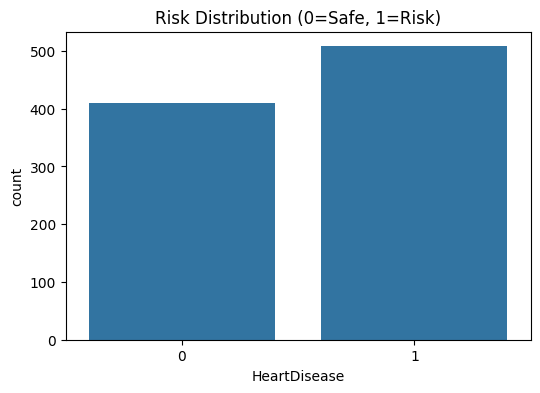

In [24]:
# Target Distribution 
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease', data=df)
plt.title('Risk Distribution (0=Safe, 1=Risk)')
plt.show()

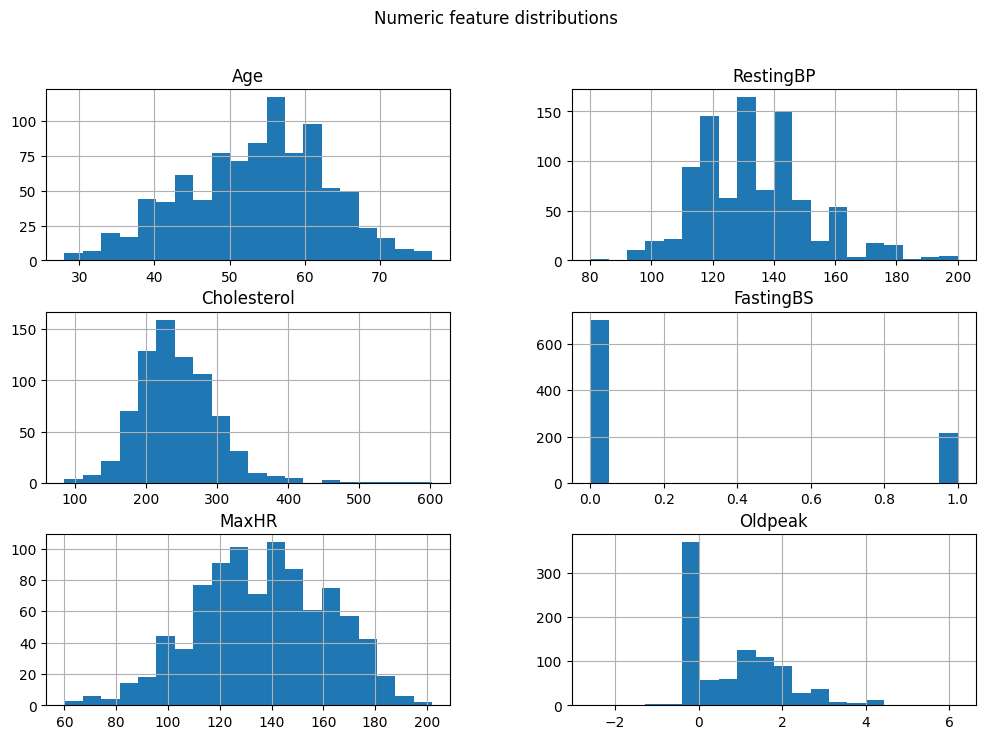

In [25]:
# Numeric feature distributions
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("HeartDisease")
df[num_cols].hist(bins=20, figsize=(12,8))
plt.suptitle("Numeric feature distributions")
plt.show()


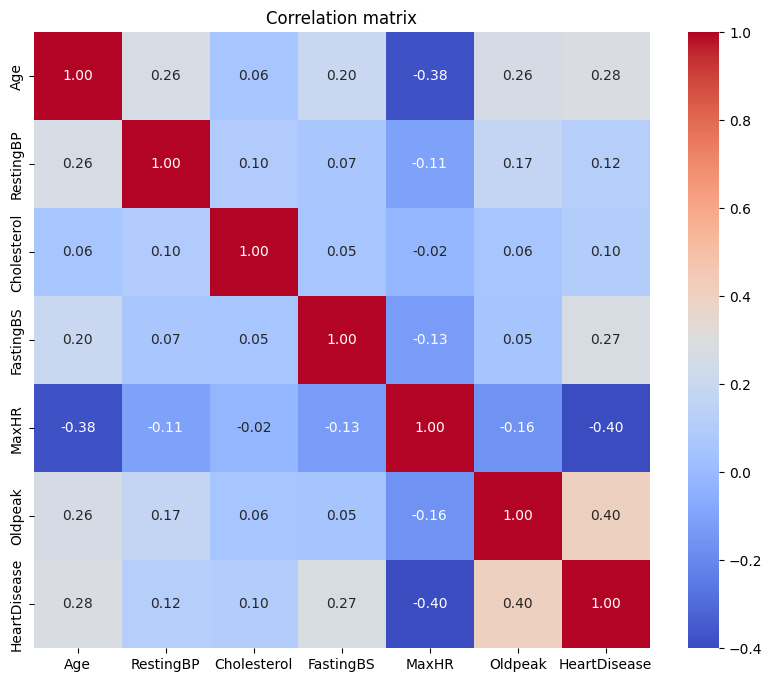

In [26]:
# Correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols + ["HeartDisease"]].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix")
plt.show()

Data Standardization & Feature Engineering  

In [27]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve
)
from scipy import stats

In [28]:
# Prepare feature lists
target = "HeartDisease"
all_features = [c for c in df.columns if c != target]

# Heuristic: numeric vs categorical
numeric_features = df[all_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in all_features if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# ---------- 4. Train/Val/Test split (70/15/15) with stratify
X = df.drop(columns=[target])
y = df[target]

# First split train vs temp (70/30)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
# Split temp into val and test 50/50 -> each 15% of total
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)
print("Train / Val / Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])


Numeric features: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categorical features: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Train / Val / Test sizes: 642 138 138


In [29]:
# Build preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

In [30]:
# Model evalutaion pipeline
def eval_model(name, model, X_test, y_test, show_report=True, plot_roc=True):
    """Evaluate model, print metrics and return dictionary of results."""
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # SVM sometimes has decision_function
        y_proba = model.decision_function(X_test)
        # scale to [0,1] via min-max for ROC (not ideal — prefer calibrating)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-12)
    else:
        y_proba = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"=== {name} Evaluation ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1-score:", f1)
    if roc is not None:
        print("ROC-AUC:", roc)
    if show_report:
        print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


    return {'name': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc}


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score


# Fitting train/val/test with preprocessor 
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

# Baseline 1: Logistic Regression (with class_weight to handle imbalance)
log_clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
log_clf.fit(X_train_proc, y_train)
res_log = eval_model("LogisticRegression", log_clf, X_test_proc, y_test)

# Baseline 2: Random Forest
rf_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_clf.fit(X_train_proc, y_train)
res_rf = eval_model("RandomForest", rf_clf, X_test_proc, y_test)

# Baseline 3: SVM (with probability=True for predict_proba)
svm_clf = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_clf.fit(X_train_proc, y_train)
res_svm = eval_model("SVM-RBF", svm_clf, X_test_proc, y_test)

# Baseline 4 (optional): Simple Neural Network (Keras)
try:
    from tensorflow.keras.models import Sequential # type: ignore
    from tensorflow.keras.layers import Dense, Dropout # type: ignore
    from tensorflow.keras.optimizers import Adam # type: ignore

    # small dense network
    input_dim = X_train_proc.shape[1]
    nn = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    nn.compile(loss='binary_crossentropy', optimizer=Adam(1e-3), metrics=['AUC'])
    nn.fit(X_train_proc, y_train, epochs=20, batch_size=32, validation_data=(X_val_proc, y_val), verbose=0)
    # wrapper for sklearn-like API: create a predict/predict_proba wrapper
    class KerasWrapper:
        def __init__(self, model): self.model = model
        def predict(self, X): return (self.model.predict(X).ravel() > 0.5).astype(int)
        def predict_proba(self, X): 
            p = self.model.predict(X).ravel()
            return np.vstack([1-p, p]).T
    nn_wrapped = KerasWrapper(nn)
    res_nn = eval_model("NeuralNet", nn_wrapped, X_test_proc, y_test)
except Exception as e:
    print("Keras NN skipped:", e)
    res_nn = None


=== LogisticRegression Evaluation ===
Accuracy: 0.855072463768116
Precision: 0.9
Recall: 0.8289473684210527
F1-score: 0.863013698630137
ROC-AUC: 0.9191426146010186

Confusion Matrix:
 [[55  7]
 [13 63]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85        62
           1       0.90      0.83      0.86        76

    accuracy                           0.86       138
   macro avg       0.85      0.86      0.85       138
weighted avg       0.86      0.86      0.86       138

=== RandomForest Evaluation ===
Accuracy: 0.8985507246376812
Precision: 0.9305555555555556
Recall: 0.881578947368421
F1-score: 0.9054054054054054
ROC-AUC: 0.9525679117147707

Confusion Matrix:
 [[57  5]
 [ 9 67]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89        62
           1       0.93      0.88      0.91        76

    accuracy                           0.90

c:\Users\Manitej\Desktop\Infosys\Heart_3\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
=== NeuralNet Evaluation ===
Accuracy: 0.8623188405797102
Precision: 0.9014084507042254
Recall: 0.8421052631578947
F1-score: 0.8707482993197279
ROC-AUC: 0.9407894736842105

Confusion Matrix:
 [[55  7]
 [12 64]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85        62
           1       0.90      0.84      0.87        76

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.87      0.86      0.86       138



Hyperparameter tuning (RandomizedSearchCV)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import numpy as np
import joblib
import os

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [100, 200, 400, 800],
    'max_depth': [None, 6, 10, 16, 24],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.6, 0.8]
}

rs = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=30, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1
)

# Use training set (only train) for search
rs.fit(X_train_proc, y_train)

print("Best RF params:", rs.best_params_)
print("Best CV ROC-AUC:", rs.best_score_)

best_rf = rs.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 6}
Best CV ROC-AUC: 0.9211318729071343


Evaluate tuned model on validation set (before calibration)

--- Best RF ---
Accuracy: 0.8985507246376812
Precision: 0.8795180722891566
Recall: 0.948051948051948
F1: 0.9125
ROC-AUC: 0.9361294443261656


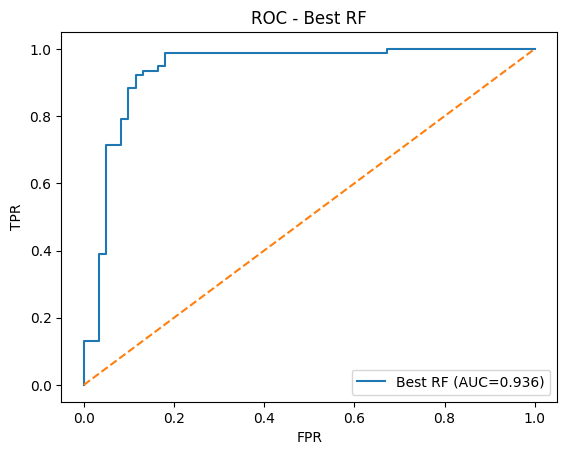

Confusion Matrix:
 [[51 10]
 [ 4 73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88        61
           1       0.88      0.95      0.91        77

    accuracy                           0.90       138
   macro avg       0.90      0.89      0.90       138
weighted avg       0.90      0.90      0.90       138



In [33]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate(model, X, y, name="Model"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1] if hasattr(model, "predict_proba") else None
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred, zero_division=0))
    print("Recall:", recall_score(y, y_pred, zero_division=0))
    print("F1:", f1_score(y, y_pred, zero_division=0))
    if y_proba is not None:
        print("ROC-AUC:", roc_auc_score(y, y_proba))
        fpr, tpr, _ = roc_curve(y, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y,y_proba):.3f})')
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {name}")
        plt.legend(); plt.show()
    print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
    print("Classification Report:\n", classification_report(y, y_pred, zero_division=0))

# validate
evaluate(best_rf, X_val_proc, y_val, name="Best RF")


Probability Calibration (CalibratedClassifierCV)

--- Calibrated RF (validation) ---
Accuracy: 0.9057971014492754
Precision: 0.8809523809523809
Recall: 0.961038961038961
F1: 0.9192546583850931
ROC-AUC: 0.9382584628486268


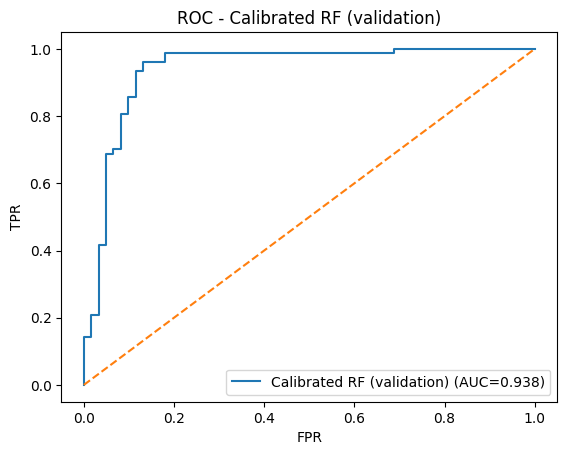

Confusion Matrix:
 [[51 10]
 [ 3 74]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89        61
           1       0.88      0.96      0.92        77

    accuracy                           0.91       138
   macro avg       0.91      0.90      0.90       138
weighted avg       0.91      0.91      0.90       138



In [34]:
from sklearn.calibration import CalibratedClassifierCV

calibrator = CalibratedClassifierCV(best_rf, method='sigmoid', cv=cv)
calibrator.fit(X_train_proc, y_train)   # fit on train only (not val/test)

# Check calibration performance on validation set
evaluate(calibrator, X_val_proc, y_val, name="Calibrated RF (validation)")

Risk Categorization

In [35]:
from sklearn.metrics import f1_score
import numpy as np
import collections

# Validation probabilities
probs_val = calibrator.predict_proba(X_val_proc)[:, 1]


# 1) Choose t2 (High-risk threshold)
t_vals = np.linspace(0.01, 0.99, 99)

f1_scores = [
    f1_score(y_val, (probs_val >= t).astype(int), zero_division=0)
    for t in t_vals
]

best_t2 = t_vals[np.argmax(f1_scores)]
print("High-risk threshold (t2):", best_t2)

# 2) Choose t1 (Low-risk cutoff)
best_t1 = best_t2 * 0.3
print("Low-risk threshold (t1):", best_t1)

# 3) Categorize into Low / Moderate / High
def get_risk(prob, t1=best_t1, t2=best_t2):
    if prob < t1:
        return "Low"
    elif prob < t2:
        return "Moderate"
    else:
        return "High"

risk_labels_val = [get_risk(p) for p in probs_val]
print("Risk distribution:", collections.Counter(risk_labels_val))

High-risk threshold (t2): 0.5700000000000001
Low-risk threshold (t1): 0.171
Risk distribution: Counter({'High': 82, 'Low': 35, 'Moderate': 21})


In [36]:
#Save model and preprocessor

os.makedirs("models", exist_ok=True)
joblib.dump(best_rf, "models/best_rf_raw.pkl")            # best RF (untuned on full train+val)
joblib.dump(calibrator, "models/best_rf_calibrated.pkl")  # calibrated wrapper
joblib.dump(preprocessor, "models/preprocessor.pkl")      # preprocessing pipeline
print("Saved models and preprocessor to /models")


Saved models and preprocessor to /models


Milestone - 3